# Ciencia de Datos, 2022

## Alan Reyes-Figueroa

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

from sklearn.decomposition import PCA, FastICA

## 1. Point data

In [2]:
# #############################################################################
# Generate sample data
rng = np.random.RandomState(2022)
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.

In [4]:
# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

X = S @ A.T                     # Generate observations

In [5]:
X[:15,:]

array([[-1.65306496e-01, -3.28653545e-01],
       [ 8.00434340e-01,  7.55293063e-01],
       [-2.24227881e+00, -3.84964394e+00],
       [ 2.49156266e+01, -1.07413253e+00],
       [-1.41078542e+00, -2.23876894e+00],
       [ 1.92634639e+00,  1.76035508e+00],
       [-3.79182963e+00, -2.66144548e+00],
       [-2.76920671e+00, -1.46833982e+00],
       [ 2.53961239e+01,  2.80396370e+00],
       [-3.18745597e+00, -2.28420605e+00],
       [ 1.73645799e-02,  2.96924423e-01],
       [ 2.36368081e+00,  8.89221532e-01],
       [-5.03386253e-01,  1.15283013e+00],
       [-1.31118289e+01, -2.79746270e+01],
       [ 3.45086195e+00,  2.46409363e+00]])

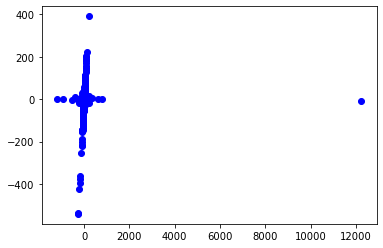

In [7]:
plt.figure()
plt.plot(X[:,0], X[:,1], 'bo')
plt.show()

In [8]:
pca = PCA()
S_pca_ = pca.fit(X).transform(X)

In [9]:
ica = FastICA(random_state=rng)
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

S_ica_ /= S_ica_.std(axis=0)

In [10]:
# #############################################################################
# Plot results

def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver((0, 0), (0, 0), x_axis, y_axis, zorder=11, width=0.01,
                       scale=6, color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

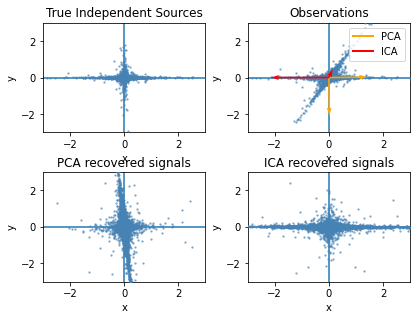

In [11]:
plt.figure()
plt.subplot(2, 2, 1)
plot_samples(S / S.std())
plt.title('True Independent Sources')

axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title('Observations')

plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()

## 2. Mixed signals

In [16]:
# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

In [17]:
S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data

In [18]:
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = S @ A.T  # Generate observations

In [19]:
X.shape

(2000, 3)

In [20]:
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [21]:
# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

In [22]:
# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

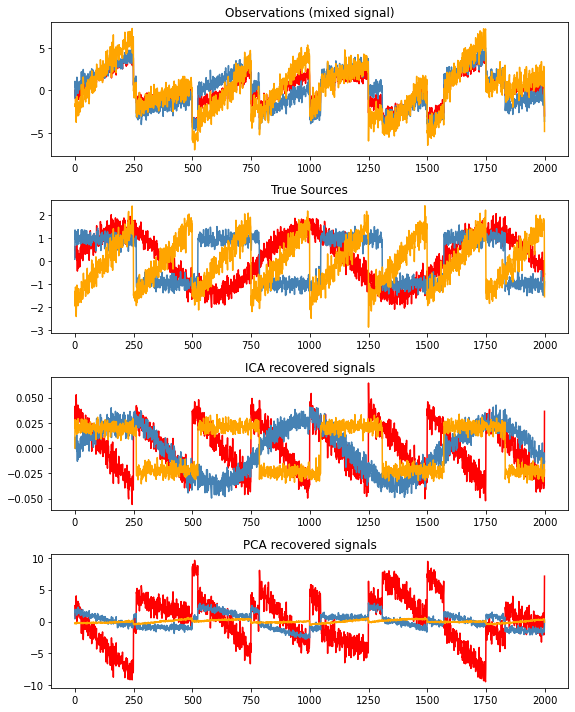

In [23]:
# #############################################################################
# Plot results

plt.figure(figsize=(8,10))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

## 3. Decompose mixed image

In [24]:
im1 = plt.imread('morro.jpg')
im2 = plt.imread('plane.jpg')
im3 = plt.imread('horse.jpg')
im4 = plt.imread('race.jpg')

print(im1.shape, im2.shape, im3.shape, im4.shape)

(321, 481, 3) (321, 481, 3) (321, 481, 3) (321, 481, 3)


In [25]:
print(im1.min(), im2.min(), im3.min(), im4.min())
print(im1.max(), im2.max(), im3.max(), im4.max())

0 0 0 0
255 184 255 255


In [26]:
(h, w, c) = im1.shape

In [27]:
# construct matrix
A = np.array([[.25, .25, .25, .25], [.2, .3, .3, .2], [.15, .4, .25, .2], [.3, .1, .2, .4]])

S = np.zeros((h*w*c, 4))
S[:,0] = im1.ravel()
S[:,1] = im2.ravel()
S[:,2] = im3.ravel()
S[:,3] = im4.ravel()

X = S @ A.T

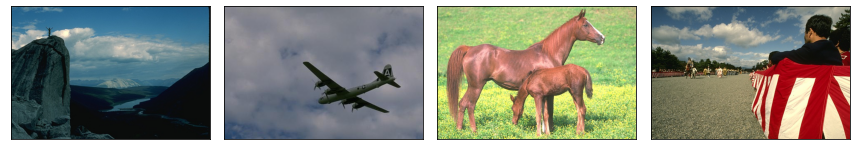

In [28]:
# #############################################################################
# Plot results

plt.figure(figsize=(12,3))
images =[im1, im2, im3, im4]
for j in range(0,4):
    plt.subplot(1, 4, j+1)
    plt.imshow(images[j])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [31]:
plt.figure(figsize=(4,3))
plt.imshow(X.reshape(images[0].shape))
plt.show()

ValueError: cannot reshape array of size 1852812 into shape (321,481,3)

<Figure size 288x216 with 0 Axes>

In [37]:
# Compute ICA
ica = FastICA(n_components=4)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [38]:
# For comparison, compute PCA
pca = PCA(n_components=4)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

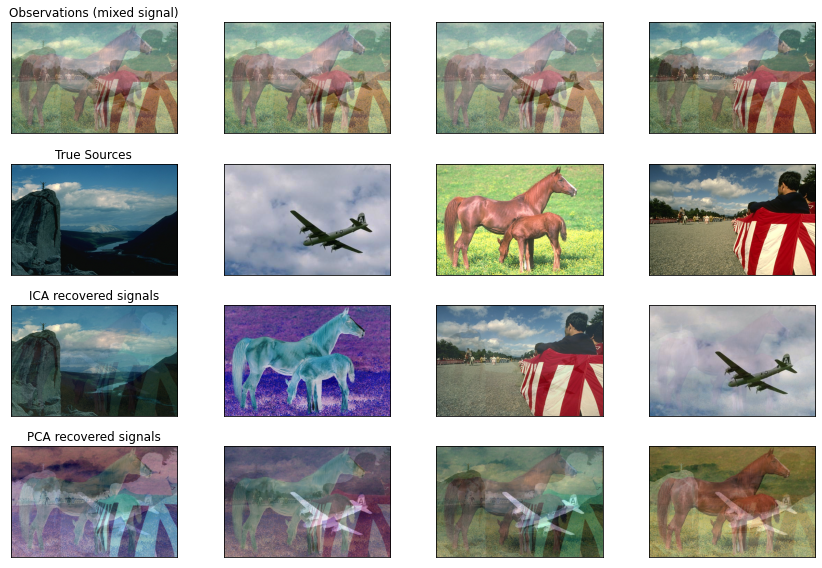

In [39]:
# #############################################################################
# Plot results

plt.figure(figsize=(12,8))

models = [X, S, S_, H]
names = ['Observations (mixed signal)', 'True Sources', 'ICA recovered signals', 'PCA recovered signals']

for i in range(0,4):
    for j in range(0,4):
        plt.subplot(4, 4, 4*i+j+1)
        if (j==0):
            plt.title(names[i])
        minn = models[i][:,j].min()
        maxx = models[i][:,j].max()
        if i in [0,1,3]:
            plt.imshow(((models[i][:,j] - minn) / (maxx-minn)).reshape(h,w,c))
        else:
            plt.imshow(((maxx - models[i][:,j]) / (maxx-minn)).reshape(h,w,c))
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()